<a href="https://colab.research.google.com/github/leangaurav/2019_12_09_dsc_weekend/blob/master/Pneumonia_Classification_Model_ImageAugmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Packages

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from IPython.core.display import display, HTML
display(HTML('<style>.container { width:100% !important; }</style>'))

In [3]:
!pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 7.3 MB/s 


In [5]:
import pydicom as dcm

In [6]:
# IMPORT PACKAGES
import warnings; warnings.filterwarnings('ignore')
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import os, random, csv
import seaborn as sns
from glob import glob
from tqdm import tqdm
%matplotlib inline

import tensorflow as tf
import tensorflow.keras as keras

# MODEL METRICS
from mlxtend.plotting import plot_confusion_matrix
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121 as PTModel, preprocess_input

from keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet import preprocess_input 

# SET VARIABLES
PATH = '/content/drive/MyDrive/capstone'
os.chdir(PATH)

DATA_DIR = os.path.join(PATH+'/')
TRAIN_IMAGES = os.path.join(DATA_DIR + 'stage_2_train_images/')
TEST_IMAGES = os.path.join(DATA_DIR + 'stage_2_test_images/')
OUTPUT_DIR = os.path.join(PATH + '')
MODEL_WEIGHTS = os.path.join(PATH + 'model_weights/')
TRAIN_IMAGES_DIR = os.path.join(DATA_DIR + 'stage_2_train_images_png/')
#if not os.path.exists(TRAIN_IMAGES_DIR): os.makedirs(TRAIN_IMAGES_DIR)
#if not os.path.exists(MODEL_WEIGHTS): os.makedirs(MODEL_WEIGHTS)

# CUSTOM MODULE
#from module.classify import *

# SET RANDOM SEED
random_state = 2020
random.seed(random_state)
np.random.seed(random_state)

# USE GPU FOR MODEL TRAINING
config = tf.compat.v1.ConfigProto(log_device_placement = True, allow_soft_placement = True)
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config = config)
list_gpu = tf.config.experimental.list_physical_devices(device_type = 'GPU')
if len(list_gpu)==1: strategy = tf.distribute.OneDeviceStrategy(device='/gpu:0')
else: strategy = tf.distribute.MirroredStrategy()
print('Num GPUs Available: ', len(list_gpu))
tf.config.optimizer.set_experimental_options({'auto_mixed_precision': True})
print('Mixed precision enabled')

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0

Num GPUs Available:  1
Mixed precision enabled


## Read Data & Prep for Model
* Read a pickle file that was saved as part of [EDA & Data Prep]

In [7]:
# Read `train_class_features.pkl` file, saved as EDA & Data Prep Module
train_class = pd.read_pickle('/content/drive/MyDrive/train_feature_engineered.pkl')
display(train_class.shape, train_class.head())

(30227, 16)

,patientId,x,y,width,height,Target,class,y_max,x_max,path,PatientSex,PatientAge,BodyPartExamined,ViewPosition,Modality,number_of_boxes
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,NaN,NaN,/content/drive/MyDrive/capstone/stage_2_train_...,F,51.0,CHEST,PA,CR,1
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,NaN,NaN,/content/drive/MyDrive/capstone/stage_2_train_...,F,48.0,CHEST,PA,CR,1
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,NaN,NaN,/content/drive/MyDrive/capstone/stage_2_train_...,M,19.0,CHEST,AP,CR,1
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal,NaN,NaN,/content/drive/MyDrive/capstone/stage_2_train_...,M,28.0,CHEST,PA,CR,1
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,531.0,477.0,/content/drive/MyDrive/capstone/stage_2_train_...,F,32.0,CHEST,AP,CR,2


In [8]:
# A dataframe with paths, classes and targets
print('Prepare a dataframe with paths, classes and targets'); print('--'*40)
path_class_target = train_class[['patientId', 'path', 'class', 'Target']].copy(deep = True)
path_class_target['path'] = (path_class_target['path']
                             .str.replace('stage_2_train_images', 'stage_2_train_images_png')
                             .str.replace('.dcm', '.png'))
path_class_target.drop_duplicates(inplace = True)
display(path_class_target.shape, path_class_target.nunique())
print('\nDistribution of target and classes')
display(path_class_target['Target'].value_counts())
print()
display(path_class_target['class'].value_counts())

Prepare a dataframe with paths, classes and targets
--------------------------------------------------------------------------------


(26684, 4)

patientId    26684
path         26684
class            3
Target           2
dtype: int64


Distribution of target and classes


0    20672
1     6012
Name: Target, dtype: int64

No Lung Opacity / Not Normal    11821
Normal                           8851
Lung Opacity                     6012
Name: class, dtype: int64

In [ ]:
#print("\n".join(path_class_target['path'].to_list()))

In [42]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
class_enc = LabelEncoder()
#path_class_target['class_idx'] = class_enc.fit_transform(path_class_target['class'])
#oh_enc = OneHotEncoder(sparse=False)
#path_class_target['class_vec'] = oh_enc.fit_transform(
 #   path_class_target['class_idx'].values.reshape(-1, 1)).tolist() 
#path_class_target.sample(3)

In [9]:
# Split the data in train, valid and test sets
print('Split the data in train, valid and test sets'); print('--'*40)

image_list = list(path_class_target['path'])
random.shuffle(image_list)
val_size = round(len(image_list)/10)
test_size = round(len(image_list)/10)
train_size = len(image_list)-test_size-val_size

X_train = image_list[:train_size]
X_valid = image_list[train_size:(train_size + val_size)]
X_test = image_list[(train_size + val_size):]

Split the data in train, valid and test sets
--------------------------------------------------------------------------------


In [10]:
print('Create Training, Validation and Test Dataframe with Path and Target'); print('--'*40)

df_train = (path_class_target.merge(pd.Series(X_train, name = 'path'), 
                                    on = 'path', 
                                    how = 'right')
          .drop(['class'], axis = 1))

df_valid = (path_class_target.merge(pd.Series(X_valid, name = 'path'), 
                                    on = 'path', 
                                    how = 'right')
          .drop(['class'], axis = 1))

df_test = (path_class_target.merge(pd.Series(X_test, name = 'path'), 
                                    on = 'path', 
                                    how = 'right')
          .drop(['class'], axis = 1))

print('Shape of the dataframes:\nTRAIN:{}\nVALID:{}\nTEST:{}'.format(df_train.shape, df_valid.shape, df_test.shape))

Create Training, Validation and Test Dataframe with Path and Target
--------------------------------------------------------------------------------
Shape of the dataframes:
TRAIN:(21348, 3)
VALID:(2668, 3)
TEST:(2668, 3)


8000 new training size


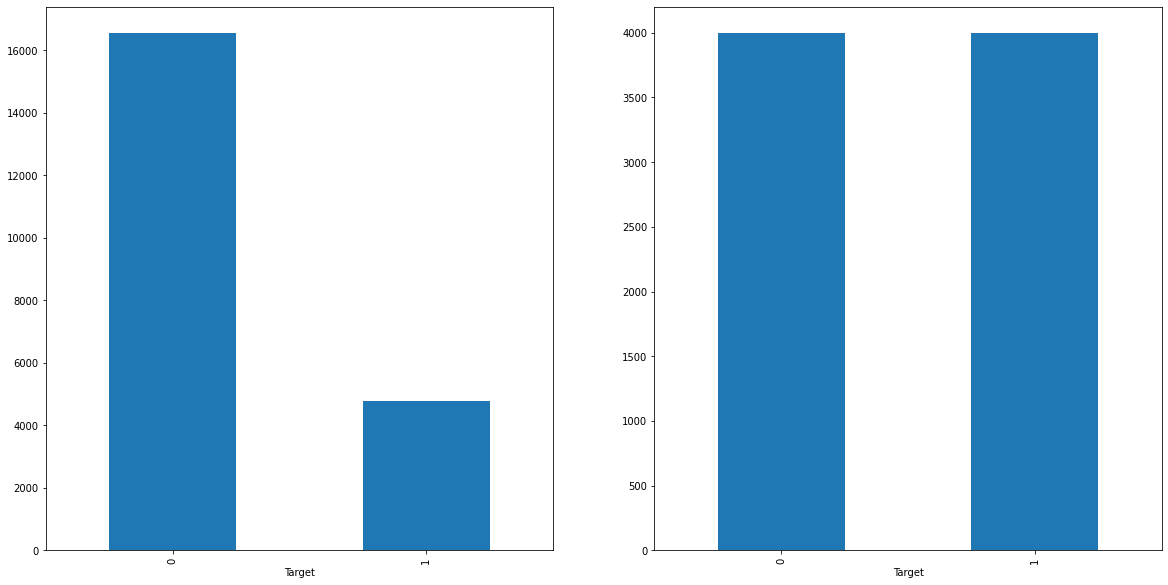

In [15]:
TRAIN_SAMPLES=12000
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
df_train.groupby('Target').size().plot.bar(ax=ax1)
train_df = df_train.groupby('Target')
train_df = train_df.apply(lambda x: x.sample(TRAIN_SAMPLES//3))
train_df = train_df.reset_index(drop=True)
train_df.groupby('Target').size().plot.bar(ax=ax2) 
print(train_df.shape[0], 'new training size')

In [16]:
train_df.shape

(8000, 3)

In [18]:
print('Training, Validation and Test set is ~equally distributed on target'); print('--'*40)
print('Distribution of target in the training set:'); 
display(pd.Series(train_df['Target']).value_counts(normalize = True).round(2))
print('\nDistribution of target in the validation set:'); 
display(pd.Series(df_valid['Target']).value_counts(normalize = True).round(2))
print('\nDistribution of target in the test set:'); 
display(pd.Series(df_test['Target']).value_counts(normalize = True).round(2))

Training, Validation and Test set is ~equally distributed on target
--------------------------------------------------------------------------------
Distribution of target in the training set:


0    0.5
1    0.5
Name: Target, dtype: float64


Distribution of target in the validation set:


0    0.78
1    0.22
Name: Target, dtype: float64


Distribution of target in the test set:


0    0.77
1    0.23
Name: Target, dtype: float64

In [ ]:
print('Save the train, valid and test dataframes for future use');print('--'*40)
df_train.to_pickle(OUTPUT_DIR + 'train_data.pkl')
df_valid.to_pickle(OUTPUT_DIR + 'valid_data.pkl')
df_test.to_pickle(OUTPUT_DIR + 'test_data.pkl')

Save the train, valid and test dataframes for future use
--------------------------------------------------------------------------------


## Model - DenseNet121

In [ ]:
# Model Parameters
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
EPOCH = 10
LEARNING_RATE = 1e-4
MONITOR = 'val_loss'
MODE = 'min'
VERBOSE = 1
FACTOR = 0.1
PATIENCE = 5
COOLDOWN = 5
BEST_MODEL = 'best_densenet.h5'
FINAL_MODEL = 'best_densenet_final.h5'
LOG_FILE = 'logs.csv'
LOSS = 'binary_crossentropy'
METRICS = ['accuracy']

In [19]:
# Model Parameters
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
EPOCH = 10
LEARNING_RATE = 1e-4
MONITOR = 'val_loss'
MODE = 'min'
VERBOSE = 1
FACTOR = 0.1
PATIENCE = 5
COOLDOWN = 5
BEST_MODEL = 'best_mobilenet.h5'
FINAL_MODEL = 'best_mobilenet_final.h5'
LOG_FILE = 'logs.csv'
LOSS = 'binary_crossentropy'
METRICS = ['accuracy']

In [20]:
train_df['Target'] = train_df['Target'].astype(str); 
df_valid['Target'] = df_valid['Target'].astype(str); 
df_test['Target'] = df_test['Target'].astype(str)

In [21]:
img_gen_args = dict(samplewise_center=False, 
                                      samplewise_std_normalization=False, 
                                      horizontal_flip = True, 
                                      vertical_flip = False, 
                                      height_shift_range = 0.05, 
                                      width_shift_range = 0.02, 
                                      rotation_range = 3, 
                                      shear_range = 0.01,
                                      fill_mode = 'nearest',
                                      zoom_range = 0.05,
                                       preprocessing_function=preprocess_input)
img_gen = ImageDataGenerator(**img_gen_args)


In [22]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, seed = None, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print('## Ignore next message from keras, values are replaced anyways: seed: {}'.format(seed))
    df_gen = img_data_gen.flow_from_directory(base_dir, 
                                     class_mode = 'sparse',
                                              seed = seed,
                                    **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values,0)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen.filepaths.extend(df_gen.filenames)
    df_gen._set_index_array()
    #df_gen.directory = '' # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen

In [23]:
try:
    with tf.device('/device:GPU:0'):
        train_generator = flow_from_dataframe(img_gen, train_df, 
                                    path_col = 'path',
                                   y_col = 'Target', 
                                  target_size = IMAGE_SIZE,
                                 color_mode = 'rgb',
                                batch_size = BATCH_SIZE)

        validation_generator = flow_from_dataframe(img_gen, df_valid, 
                                     path_col = 'path',
                                    y_col = 'Target', 
                                    target_size = IMAGE_SIZE,
                                     color_mode = 'rgb',
                                    batch_size = 256) # we can use much larger batches for evaluation

except RuntimeError as e:
    print(e)

## Ignore next message from keras, values are replaced anyways: seed: None
Found 0 images belonging to 0 classes.
Reinserting dataframe: 8000 images
## Ignore next message from keras, values are replaced anyways: seed: None
Found 0 images belonging to 0 classes.
Reinserting dataframe: 2668 images


In [24]:
test_generator = flow_from_dataframe(img_gen, df_test, 
                                     path_col = 'path',
                                    y_col = 'Target', 
                                    target_size = IMAGE_SIZE,
                                     color_mode = 'rgb',
                                    batch_size = 32)

## Ignore next message from keras, values are replaced anyways: seed: None
Found 0 images belonging to 0 classes.
Reinserting dataframe: 2668 images


(32, 224, 224, 3) (32,)


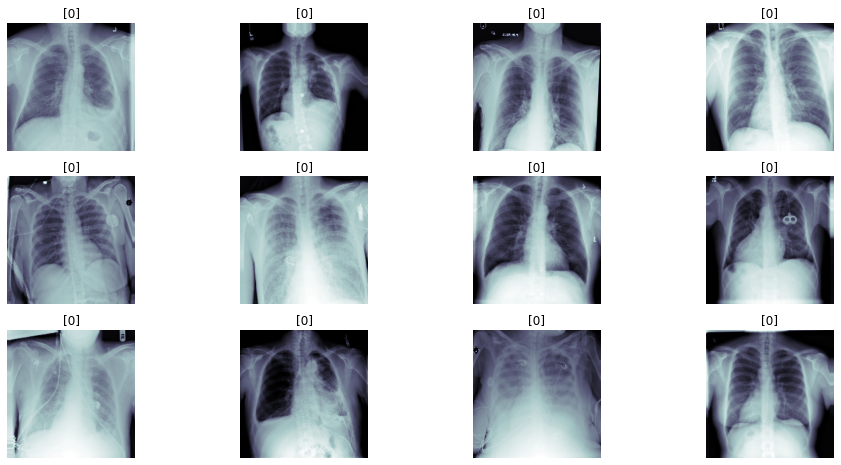

In [45]:
t_x, t_y = next(train_generator)
print(t_x.shape, t_y.shape)
fig, m_axs = plt.subplots(3, 4, figsize = (16, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    c_ax.set_title('%s'% [np.argmax(c_y)])
    c_ax.axis('off')

In [28]:
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda, AvgPool2D
from keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam
from keras import layers
from keras.applications.densenet import DenseNet201, DenseNet121
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau,CSVLogger


In [ ]:
#Densenet
def build_model():
    print('Create a `DenseNet121` model'); print('--'*40)
    input_shape = (224,224, 3)
    inputs = Input(shape = input_shape)
    initializer = tf.keras.initializers.GlorotNormal()
    
    base_model = DenseNet121(include_top = False, input_tensor = inputs, weights ='imagenet')
    
    densenet = Model(inputs = inputs, outputs = base_model.layers[-1].output, name = 'DenseNet121')
    
    model = Sequential(name = 'DenseNet121')
    model.add(densenet)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation = 'sigmoid', kernel_initializer = initializer))
    model.summary()
    return model

def callbacks():
    
    model.compile(optimizer = Adam(lr = LEARNING_RATE), loss = LOSS, metrics = METRICS)
    
    cp = ModelCheckpoint(filepath = MODEL_WEIGHTS + BEST_MODEL, monitor = MONITOR, 
                         verbose = VERBOSE, save_best_only = True, mode = MODE)
    
    if os.path.exists(MODEL_WEIGHTS + LOG_FILE): os.remove(MODEL_WEIGHTS + LOG_FILE)
    csv_logger = CSVLogger(MODEL_WEIGHTS + LOG_FILE, append = True)
    lrscheduler = ReduceLROnPlateau(monitor = MONITOR, factor = FACTOR, 
                                    patience = PATIENCE, verbose = VERBOSE, 
                                    mode = MODE, cooldown = COOLDOWN)
    
    callbacks_list = [cp, csv_logger, lrscheduler]
    return callbacks_list

In [ ]:
print('Lets fit the model.....')
#K.clear_session()
with strategy.scope():
    model = build_model()
    callbacks_list = callbacks()
    
    history = model.fit_generator(generator = train_generator, 
                                  steps_per_epoch = train_generator.n//BATCH_SIZE,
                                  epochs = EPOCH, verbose = VERBOSE, 
                                  callbacks = callbacks_list,
                                  validation_data = validation_generator)
    print('Save the final weights'); print('--'*40)
    model.save(MODEL_WEIGHTS + FINAL_MODEL)

Lets fit the model.....
Create a `DenseNet121` model
--------------------------------------------------------------------------------
29097984/29084464 [==============================] - 1s 0us/step
Model: "DenseNet121"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 DenseNet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 1)                 1025      
                                                                 
Total params: 7,038,529
Trainable params: 6,954,881
No

In [ ]:
print('Reloading model weights and lets evaluate on validation set'); print('--'*40)
model.load_weights(MODEL_WEIGHTS + BEST_MODEL)

Reloading model weights and lets evaluate on validation set
--------------------------------------------------------------------------------


In [ ]:
print('Evaluate the model on validation data'); print('--'*40)

loss, accuracy = model.evaluate_generator(generator = validation_generator)
print(f'Loss: {round(loss, 3)}, Accuracy: {round(float(accuracy), 3)}')

Evaluate the model on validation data
--------------------------------------------------------------------------------
Loss: 0.342, Accuracy: 0.852


In [ ]:
print('Predict on the validation data'); print('--'*40)
validation_generator.reset()
valid_pred_roc = model.predict_generator(generator = validation_generator,
                                         verbose = 1)
valid_pred = []
for i in valid_pred_roc:
    if i >= 0.5: valid_pred.append(1)
    else: valid_pred.append(0)
y_valid = df_valid['Target'].astype(int).values

Predict on the validation data
--------------------------------------------------------------------------------
11/11 [==============================] - 56s 5s/step


In [ ]:
print('Predict on the test data'); print('--'*40)
test_generator.reset()
test_pred_roc = model.predict_generator(generator = test_generator,
                              verbose = 1)
test_pred = []
for i in test_pred_roc:
    if i >= 0.5: test_pred.append(1)
    else: test_pred.append(0)
y_test = df_test['Target'].astype(int).values

Predict on the test data
--------------------------------------------------------------------------------
84/84 [==============================] - 66s 782ms/step


In [ ]:
display(pd.Series(y_valid).value_counts(), pd.Series(y_test).value_counts())

0    2071
1     597
dtype: int64

0    2042
1     626
dtype: int64

ROC Curve for the validation data
--------------------------------------------------------------------------------
AUC: 0.487


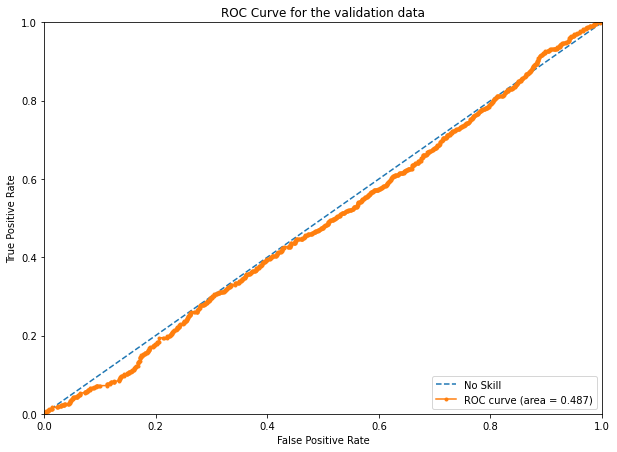

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
print('ROC Curve for the validation data'); print('--'*40)

roc_auc_valid = roc_auc_score(y_valid, np.array(valid_pred_roc).reshape(-1))
print('AUC: {:0.3f}'.format(roc_auc_valid))

fig = plt.figure(figsize = (10, 7.2))
fpr, tpr, thresholds = roc_curve(y_valid, np.array(valid_pred_roc).reshape(-1))
plt.title('ROC Curve for the validation data')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.axis([0, 1, 0, 1])
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'No Skill')
plt.plot(fpr, tpr, marker = '.', label = 'ROC curve (area = %0.3f)' % roc_auc_valid)
plt.legend(loc = 'lower right')
plt.show()

ROC Curve for the test data
--------------------------------------------------------------------------------
AUC: 0.491


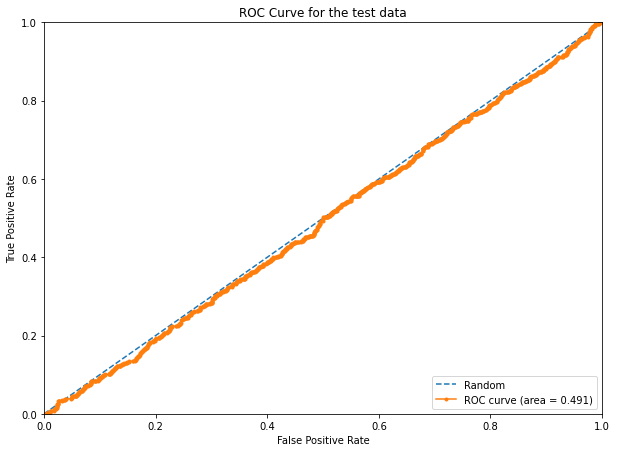

In [ ]:
print('ROC Curve for the test data'); print('--'*40)

roc_auc_test = roc_auc_score(y_test, np.array(test_pred_roc).reshape(-1))
print('AUC: {:0.3f}'.format(roc_auc_test))

fig = plt.figure(figsize = (10, 7.2))
fpr, tpr, thresholds = roc_curve(y_test, np.array(test_pred_roc).reshape(-1))
plt.title('ROC Curve for the test data')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.axis([0, 1, 0, 1])
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Random')
plt.plot(fpr, tpr, marker = '.', label = 'ROC curve (area = %0.3f)' % roc_auc_test)
plt.legend(loc = 'lower right')
plt.show()

Confusion Matrix on the test data
--------------------------------------------------------------------------------


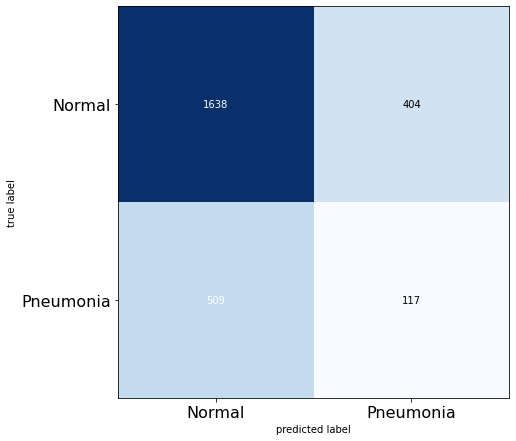

In [ ]:
from sklearn.metrics import confusion_matrix
print('Confusion Matrix on the test data'); print('--'*40)
cm = confusion_matrix(y_test, test_pred)
plot_confusion_matrix(cm, figsize = (10, 7.2), cmap = plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize = 16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize = 16)
plt.show()

In [ ]:
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, roc_auc_score,classification_report
from sklearn.metrics import classification_report

print('Classification Report on the test data'); print('--'*60)
print(classification_report(y_test, test_pred, target_names = ['Normal', 'Pneumonia']))

Classification Report on the test data
------------------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

      Normal       0.76      0.80      0.78      2042
   Pneumonia       0.22      0.19      0.20       626

    accuracy                           0.66      2668
   macro avg       0.49      0.49      0.49      2668
weighted avg       0.64      0.66      0.65      2668



## **MObileNet With Image** **Augmentation**

In [29]:
#Mobile net
def build_model():
    print('Create a `MobileNet` model'); print('--'*40)
    input_shape = (224,224, 3)
    inputs = Input(shape = input_shape)
    initializer = tf.keras.initializers.GlorotNormal()
    
    base_model = MobileNet(include_top = False, input_tensor = inputs, weights ='imagenet')
    
    densenet = Model(inputs = inputs, outputs = base_model.layers[-1].output, name = 'MobileNet')
    
    model = Sequential(name = 'MobileNet')
    model.add(densenet)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation = 'sigmoid', kernel_initializer = initializer))
    model.summary()
    return model

def callbacks():
    
    model.compile(optimizer = Adam(lr = LEARNING_RATE), loss = LOSS, metrics = METRICS)
    
    cp = ModelCheckpoint(filepath = MODEL_WEIGHTS + BEST_MODEL, monitor = MONITOR, 
                         verbose = VERBOSE, save_best_only = True, mode = MODE)
    
    if os.path.exists(MODEL_WEIGHTS + LOG_FILE): os.remove(MODEL_WEIGHTS + LOG_FILE)
    csv_logger = CSVLogger(MODEL_WEIGHTS + LOG_FILE, append = True)
    lrscheduler = ReduceLROnPlateau(monitor = MONITOR, factor = FACTOR, 
                                    patience = PATIENCE, verbose = VERBOSE, 
                                    mode = MODE, cooldown = COOLDOWN)
    
    callbacks_list = [cp, csv_logger, lrscheduler]
    return callbacks_list

In [31]:
print('Lets fit the model.....')
#K.clear_session()
with strategy.scope():
    model = build_model()
    callbacks_list = callbacks()
    
    history = model.fit_generator(generator = train_generator, 
                                  steps_per_epoch = train_generator.n//BATCH_SIZE,
                                  epochs = EPOCH, verbose = VERBOSE, 
                                  callbacks = callbacks_list,
                                  validation_data = validation_generator)
    print('Save the final weights'); print('--'*40)
    model.save(MODEL_WEIGHTS + FINAL_MODEL)

Lets fit the model.....
Create a `MobileNet` model
--------------------------------------------------------------------------------
Model: "MobileNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobileNet (Functional)      (None, 7, 7, 1024)        3228864   
                                                                 
 global_average_pooling2d_1   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 3,229,889
Trainable params: 3,208,001
Non-trainable params: 21,888
__________________________________________

In [32]:
print('Reloading model weights and lets evaluate on validation set'); print('--'*40)
model.load_weights(MODEL_WEIGHTS + BEST_MODEL)

Reloading model weights and lets evaluate on validation set
--------------------------------------------------------------------------------


In [33]:
print('Evaluate the model on validation data'); print('--'*40)

loss, accuracy = model.evaluate_generator(generator = validation_generator)
print(f'Loss: {round(loss, 3)}, Accuracy: {round(float(accuracy), 3)}')

Evaluate the model on validation data
--------------------------------------------------------------------------------
Loss: 0.411, Accuracy: 0.822


In [34]:
print('Predict on the validation data'); print('--'*40)
validation_generator.reset()
valid_pred_roc = model.predict_generator(generator = validation_generator,
                                         verbose = 1)
valid_pred = []
for i in valid_pred_roc:
    if i >= 0.5: valid_pred.append(1)
    else: valid_pred.append(0)
y_valid = df_valid['Target'].astype(int).values

Predict on the validation data
--------------------------------------------------------------------------------
11/11 [==============================] - 56s 5s/step


In [35]:
print('Predict on the test data'); print('--'*40)
test_generator.reset()
test_pred_roc = model.predict_generator(generator = test_generator,
                              verbose = 1)
test_pred = []
for i in test_pred_roc:
    if i >= 0.5: test_pred.append(1)
    else: test_pred.append(0)
y_test = df_test['Target'].astype(int).values

Predict on the test data
--------------------------------------------------------------------------------
84/84 [==============================] - 841s 10s/step


In [36]:
display(pd.Series(y_valid).value_counts(), pd.Series(y_test).value_counts())

0    2071
1     597
dtype: int64

0    2042
1     626
dtype: int64

ROC Curve for the validation data
--------------------------------------------------------------------------------
AUC: 0.503


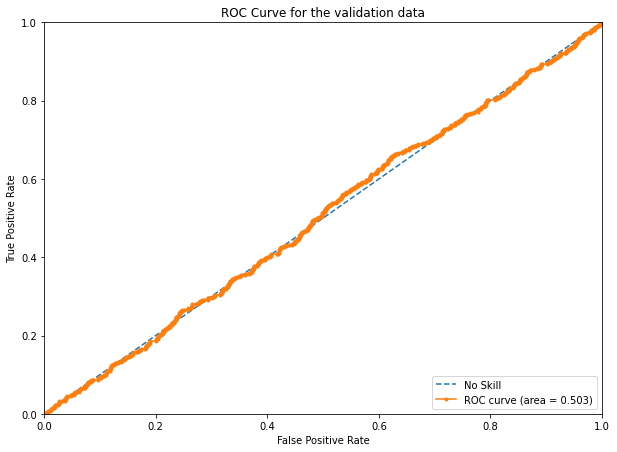

In [37]:
from sklearn.metrics import roc_curve, roc_auc_score
print('ROC Curve for the validation data'); print('--'*40)

roc_auc_valid = roc_auc_score(y_valid, np.array(valid_pred_roc).reshape(-1))
print('AUC: {:0.3f}'.format(roc_auc_valid))

fig = plt.figure(figsize = (10, 7.2))
fpr, tpr, thresholds = roc_curve(y_valid, np.array(valid_pred_roc).reshape(-1))
plt.title('ROC Curve for the validation data')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.axis([0, 1, 0, 1])
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'No Skill')
plt.plot(fpr, tpr, marker = '.', label = 'ROC curve (area = %0.3f)' % roc_auc_valid)
plt.legend(loc = 'lower right')
plt.show()

ROC Curve for the test data
--------------------------------------------------------------------------------
AUC: 0.490


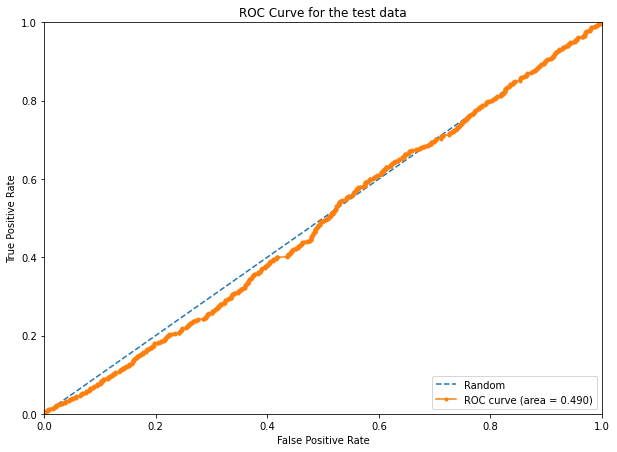

In [38]:
print('ROC Curve for the test data'); print('--'*40)

roc_auc_test = roc_auc_score(y_test, np.array(test_pred_roc).reshape(-1))
print('AUC: {:0.3f}'.format(roc_auc_test))

fig = plt.figure(figsize = (10, 7.2))
fpr, tpr, thresholds = roc_curve(y_test, np.array(test_pred_roc).reshape(-1))
plt.title('ROC Curve for the test data')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.axis([0, 1, 0, 1])
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Random')
plt.plot(fpr, tpr, marker = '.', label = 'ROC curve (area = %0.3f)' % roc_auc_test)
plt.legend(loc = 'lower right')
plt.show()

Confusion Matrix on the test data
--------------------------------------------------------------------------------


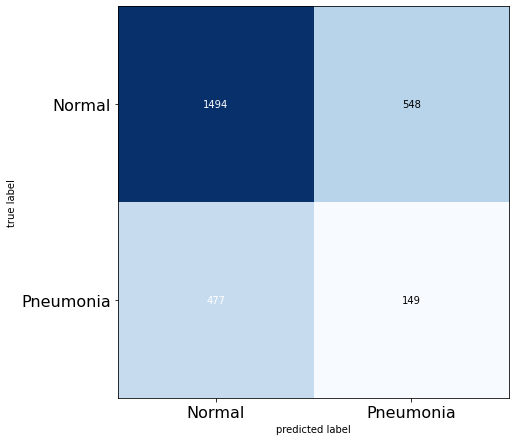

In [39]:
from sklearn.metrics import confusion_matrix
print('Confusion Matrix on the test data'); print('--'*40)
cm = confusion_matrix(y_test, test_pred)
plot_confusion_matrix(cm, figsize = (10, 7.2), cmap = plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize = 16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize = 16)
plt.show()

In [40]:
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, roc_auc_score,classification_report
from sklearn.metrics import classification_report

print('Classification Report on the test data'); print('--'*60)
print(classification_report(y_test, test_pred, target_names = ['Normal', 'Pneumonia']))

Classification Report on the test data
------------------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

      Normal       0.76      0.73      0.74      2042
   Pneumonia       0.21      0.24      0.23       626

    accuracy                           0.62      2668
   macro avg       0.49      0.48      0.48      2668
weighted avg       0.63      0.62      0.62      2668

